<h1>ALA 470 Final Project</h1>

<p>By Haley Johnson</p>

In [1]:
import os
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt, mpld3
import matplotlib.style as style
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

In [2]:
sns.set_style("dark")
sns.color_palette("Paired")
sns.set_context("poster")
sns.set(font_scale = 1)

<h2>Load Data</h2>

In [3]:
df = pd.read_csv("fake.csv")

In [4]:
with open('stopwords.txt') as s:
    stopwords = s.read()

In [5]:
stopwords = stopwords.split(" ")

<h2>Preprocess</h2>

<h3>Tokenize</h3>

In [6]:
df['text'] = df['text'].astype(str)
df['text_normalized'] = df['text'].str.lower()
df['sentences'] = df['text_normalized'].apply(lambda s: [sent for sent in nltk.sent_tokenize(s)])
df['tokens'] = df['text_normalized'].apply(lambda t: [word for sent in nltk.sent_tokenize(t) for word in nltk.word_tokenize(sent)])

In [7]:
df['title'] = df['title'].astype(str)
df['title_normalized'] = df['title'].str.lower()
df['title_tokens'] = df['title_normalized'].apply(nltk.word_tokenize)

In [8]:
df['non_stopwords'] = df['tokens'].apply(lambda x: [w for w in x if w not in stopwords])
df['non_stopwords_count'] = df['non_stopwords'].apply(len)

In [9]:
df['title_no_stopwords'] = df['title_tokens'].apply(lambda t: [w for w in t if w not in stopwords])

<h2>Basic Text Exploration</h2>

In [10]:
targets = ['hillary clinton', 'bill clinton', 'donald trump', 'nancy pelosi', 'global warming', 'vaccines', 
           'democrat', 'republican', 'main stream media', 'washington d.c.', 'immigrants', 'election']

for target in targets:
    res = df['text_normalized'].str.contains(target)
    counts = df['text_normalized'].str.count(target)
    print(f"There are {res.sum()} articles that mention '{target}'")
    print(f"'{target}' is mentioned a total of {counts.sum()} times \n")
    
    

There are 3312 articles that mention 'hillary clinton'
'hillary clinton' is mentioned a total of 8479 times 

There are 663 articles that mention 'bill clinton'
'bill clinton' is mentioned a total of 1324 times 

There are 2871 articles that mention 'donald trump'
'donald trump' is mentioned a total of 6081 times 

There are 46 articles that mention 'nancy pelosi'
'nancy pelosi' is mentioned a total of 49 times 

There are 128 articles that mention 'global warming'
'global warming' is mentioned a total of 288 times 

There are 91 articles that mention 'vaccines'
'vaccines' is mentioned a total of 487 times 

There are 2699 articles that mention 'democrat'
'democrat' is mentioned a total of 7209 times 

There are 2039 articles that mention 'republican'
'republican' is mentioned a total of 4867 times 

There are 26 articles that mention 'main stream media'
'main stream media' is mentioned a total of 29 times 

There are 95 articles that mention 'washington d.c.'
'washington d.c.' is ment

In [11]:
sentences_lst = df['sentences'].to_list()
count = 0

for sentences in sentences_lst:
    for s in sentences:
        if re.match(r'\bhillary clinton\b', s):
            count += 1

<h2>NLTK</h2>

<h3>Top Tokens by Type</h3>

In [12]:
types = list(df['type'].unique())

In [13]:
top_tokens = []
for i in range(len(types)):
    matches = df[df['type'] == types[i]]
    exploded_tokens = matches.explode('non_stopwords')
    exploded_tokens = exploded_tokens[pd.isnull(exploded_tokens['non_stopwords']) == False]
    top_tokens.append(exploded_tokens['non_stopwords'].value_counts())

<h3>Filter Out Puncutation Tokens</h3>

In [14]:
punctuation = ["'", "'", '"', '"', ".", "?", ",", "!", "-", ",", ".", '”', '“', ";", ":", "(", ")", "’",
               '–', "&", '``', "''", "'s", "...", ":", "@", "‘"]

In [15]:
for i in range(len(top_tokens)):
    current = top_tokens[i].reset_index().rename(columns = {'index': 'token', 'non_stopwords': 'count'} )
    current = current[current['token'].apply(lambda s: s not in punctuation) == True]
    top_tokens[i] = current

<h2>Visualize Tokens</h2>

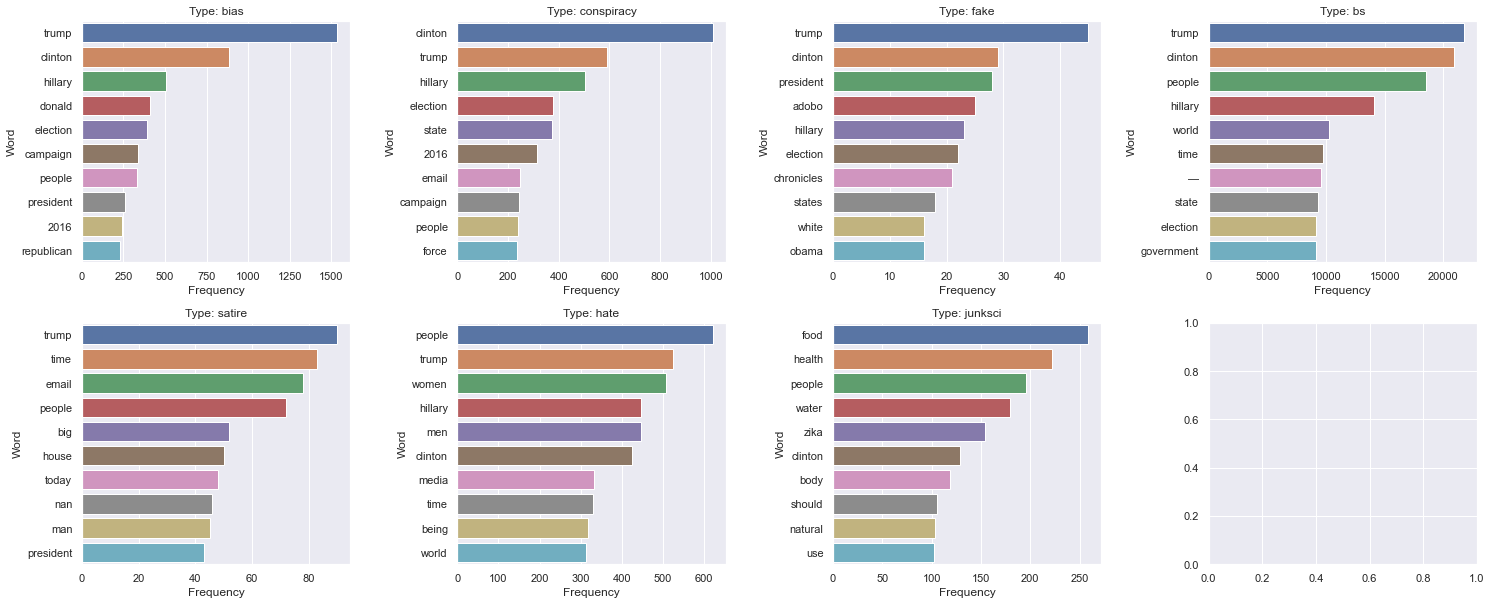

In [16]:
fig, axes = plt.subplots(2, 4)
fig.set_size_inches(25, 10)
fig.subplots_adjust(hspace = 0.25, wspace = 0.4)

for i, ax in enumerate(axes.flatten()):
    if i == 7:
        break
    top = top_tokens[i].sort_values(by = 'count', ascending = False)[:10]
    grid = sns.barplot(x = top['count'], y = top['token'], ax = ax)
    grid.set(title = f"Type: {types[i]}", xlabel = 'Frequency', ylabel = 'Word')
    

<h3>Named Entity Recognition</h3>
<p><a href = "https://pythonprogramming.net/natural-language-toolkit-nltk-part-speech-tagging/">NLTK Parts of Speech Tags</a>

In [17]:
def get_target_entities(s):
    '''
    Takes in a text fielld
    
    Returns all the entities 
    matching the labels in the
    targets list
    '''
    items = []
    s = str(s)
    tokens = [word for sent in nltk.sent_tokenize(s) for word in nltk.word_tokenize(sent)]
    targets = ['PERSON', 'GPE', 'ORGANIZATION', 'FACILITY', 'NORP', 'ORG', 
               'LOC', 'EVENT', 'LAW']
    tagged = nltk.pos_tag(tokens)
    entities = nltk.chunk.ne_chunk(tagged)

    for entity in entities.subtrees():
        if entity.label() in targets:
            name = []
            for leaf in entity.leaves():
                name.append(leaf[0])
            items.append(" ".join(name))
    return items

In [18]:
df['entities'] = df['non_stopwords'].apply(get_target_entities)

<h4>NER On Title</h4>

In [19]:
df['title_entities'] = df['title_no_stopwords'].apply(get_target_entities)

<h2>Visualize Top Entities</h2>

<h3>Text</h3>

In [20]:
top = []
for i in range(len(types)):
    matches = df[df['type'] == types[i]]
    exploded = matches.explode('entities')
    exploded = exploded[pd.isnull(exploded['entities']) == False]
    exploded['entities'] = exploded['entities'].apply(lambda s: s[1:])
    top.append(exploded['entities'].value_counts())

In [21]:
fake = top[2]
top = top[:2] + top[3:]

Text(0.5, 0.98, 'Most Common Entities in Fake News Articles')

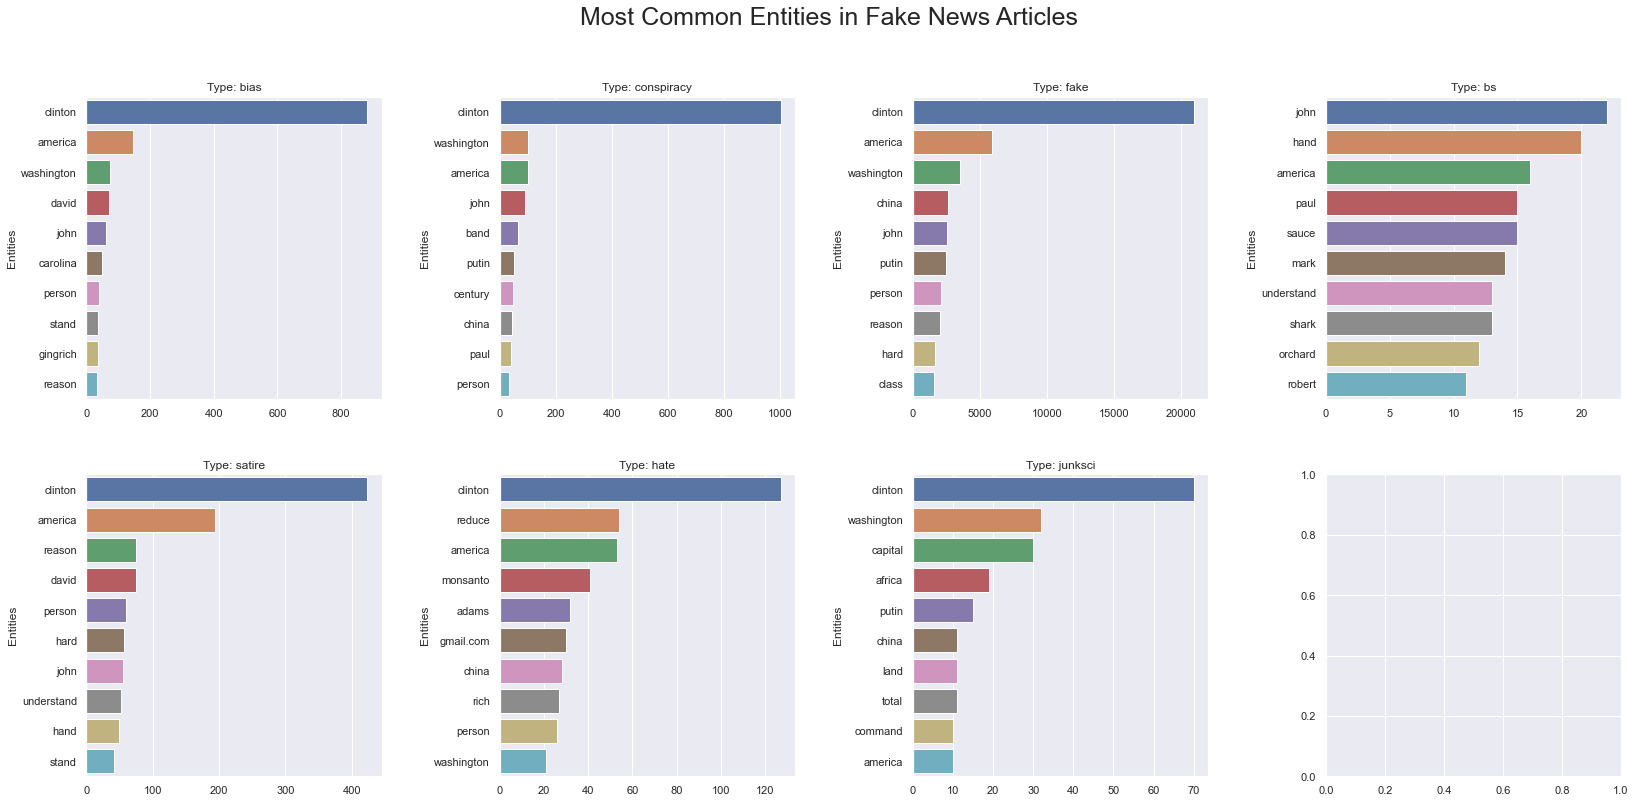

In [22]:
fig, axes = plt.subplots(2, 4)
fig.set_size_inches(27.5, 12.5)
fig.subplots_adjust(hspace = 0.25, wspace = 0.4)

for i, ax in enumerate(axes.flatten()):
    if i == 7:
        break
    t = types[i]
    top_subset = top[i][:10]
    grid = sns.barplot(x = top_subset.values, y = top_subset.index, ax = ax)
    grid.set(ylabel = 'Entities', title = f"Type: {t}")
    
fig.suptitle("Most Common Entities in Fake News Articles", fontsize = 25)

<h3>Title</h3>

In [23]:
top_ners = []
for i in range(len(types)):
    matches = df[df['type'] == types[i]]
    exploded = matches.explode('title_entities')
    exploded = exploded[pd.isnull(exploded['title_entities']) == False]
    exploded['title_entities'] = exploded['title_entities'].apply(lambda s: s[1:])
    top_ners.append(exploded['title_entities'].value_counts())

Text(0.5, 0.98, 'Most Common Entities in Titles of Fake News Articles')

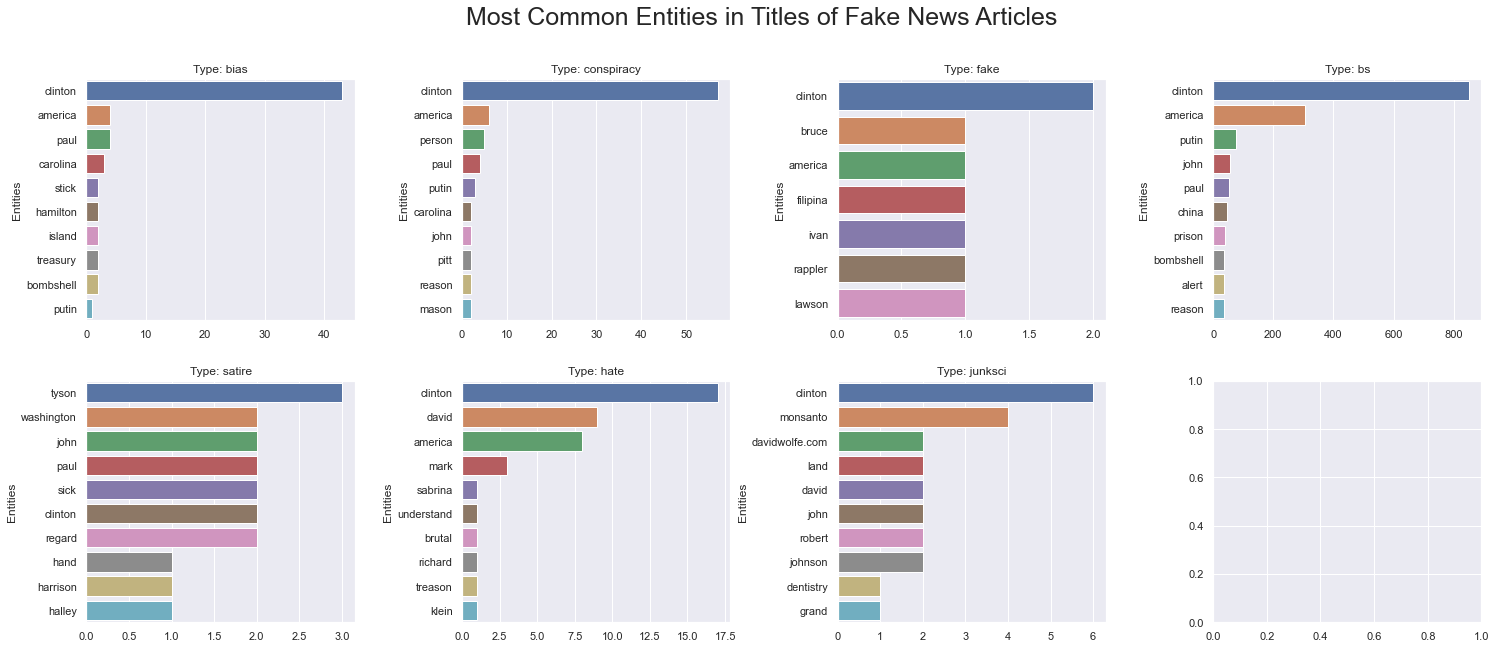

In [24]:
fig, axes = plt.subplots(2, 4)
fig.set_size_inches(25, 10)
fig.subplots_adjust(hspace = 0.25, wspace = 0.4)

for i, ax in enumerate(axes.flatten()):
    if i == 7:
        break
    t = types[i]
    top_subset = top_ners[i][:10]
    grid = sns.barplot(x = top_subset.values, y = top_subset.index, ax = ax)
    grid.set(ylabel = 'Entities', title = f"Type: {t}")
    
fig.suptitle("Most Common Entities in Titles of Fake News Articles", fontsize = 25)

<h2>Final Project Visualizations!</h2>

<a href="https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08">Seaborn Color Palettes</a>

In [25]:
regexs = ['clintons?', 'american?s?', 'china', 'washington', 'ryan', 'paul', 
          'putin', 'gingrich', 'russian?', 'african?', 'trump', 'obama', 
          'monsanto', 'islam', 'muslims?', 'leftists?', 'jews?', 
          'treasury', 'christians?', 'voter?s?d?', 'elections?', 'ballots?', 
          'vaccines?', 'gmos?', 'scientists?', 'immigrants?', 'emails?']

labels = ['Clinton', 'America', 'China', 'Washington', 'Paul Ryan', 'Rand Paul', 'Vladimir Putin', 
          'Newt Gingrich', 'Russia', 'Africa', 'Donald Trump', 'Barack Obama', 'Monsanto', 
          'Islam', 'Muslim', 'Leftist', 'Jew', 'Treasury', 'Christian', 'Voter', 
          'Election', 'Ballot', 'Vaccine', 'GMO', 'Scientist', 'Immigrants', 'Emails']

targets = sorted(list(zip(labels, regexs)))

In [26]:
palette = sns.cubehelix_palette(light = .7, n_colors = 25)

Text(0.5, 0.98, 'Most Common Things Mentioned in Fake News Articles by Type')

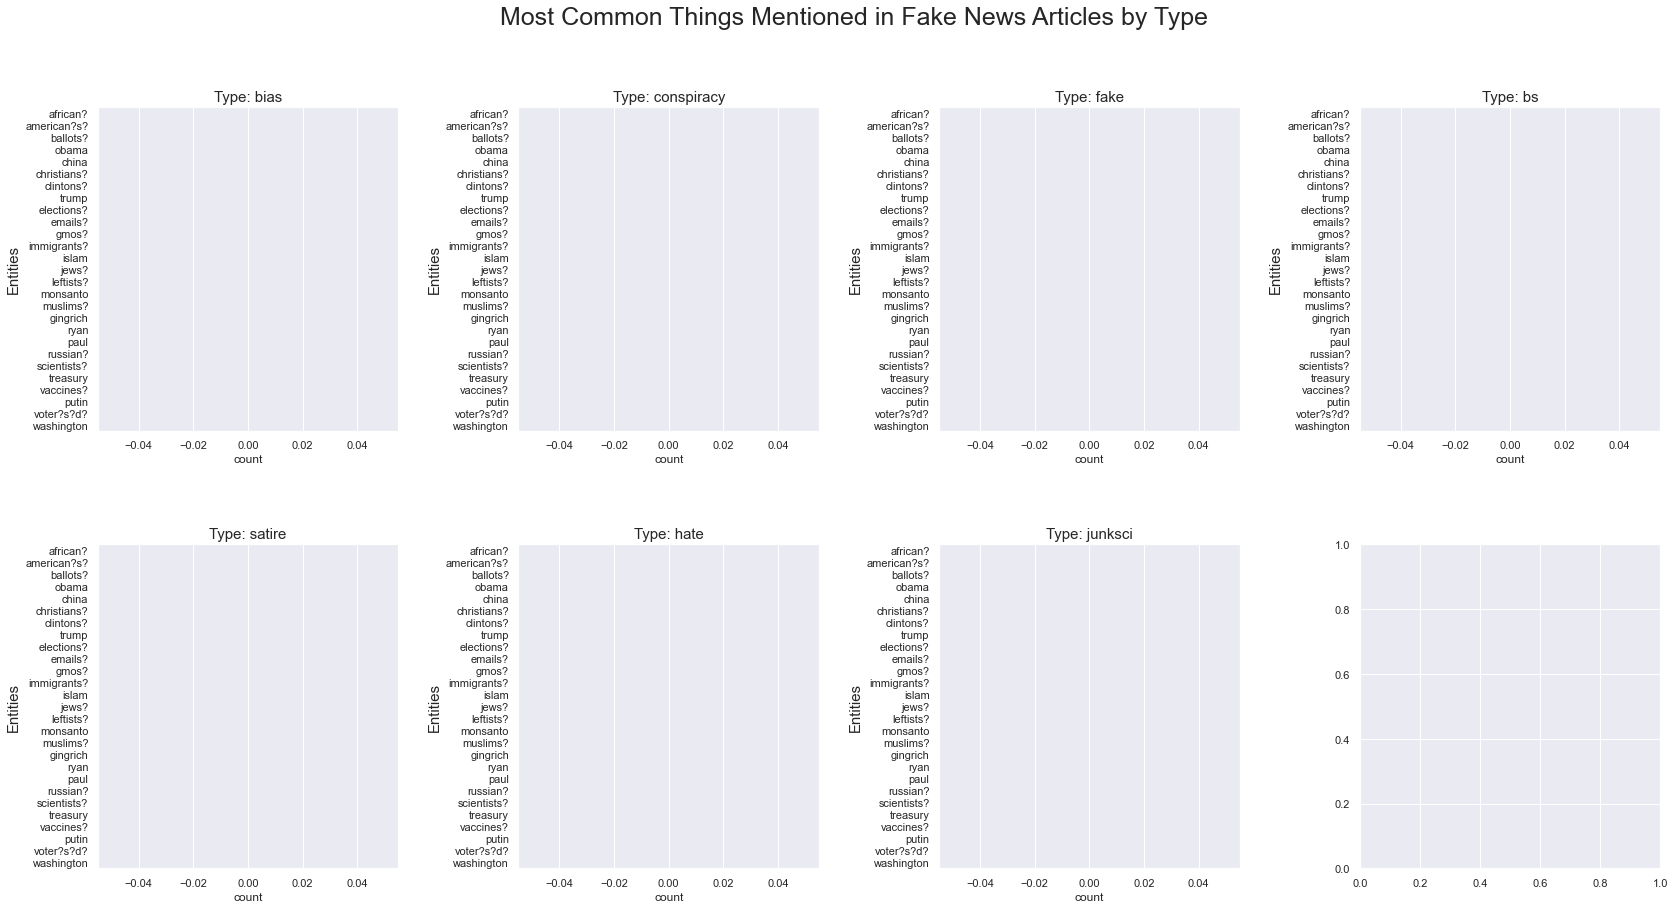

In [27]:
rcParams['figure.figsize'] = 28,14

fig, axes = plt.subplots(2, 4)
# fig.set_size_inches(40, 20)
fig.subplots_adjust(hspace = 0.35, wspace = 0.4)

for i, ax in enumerate(axes.flatten()):
    if i == 7:
        break
    t = types[i]
    matches = {}
    matches_df = df[df['type'] == t]
    for target, label in targets:
        matches[label] = matches_df['text_normalized'].str.contains(r"{}".format(target)).sum()
#     matches = {k:v for k, v in matches.items() if v > 3}    
    temp = pd.DataFrame(matches.items(), columns = ['entity', 'count'])
    num_items = len(matches.keys())
    grid = sns.barplot(x = temp['count'], y = temp['entity'],
                       palette = sns.color_palette('GnBu_d',  num_items), ax = ax)
    grid.set_ylabel('Entities', fontsize = 15)
    grid.set_title(f"Type: {t}", fontsize = 15)
fig.suptitle("Most Common Things Mentioned in Fake News Articles by Type", fontsize = 25)

<h3>Variant With Percentages</h3>

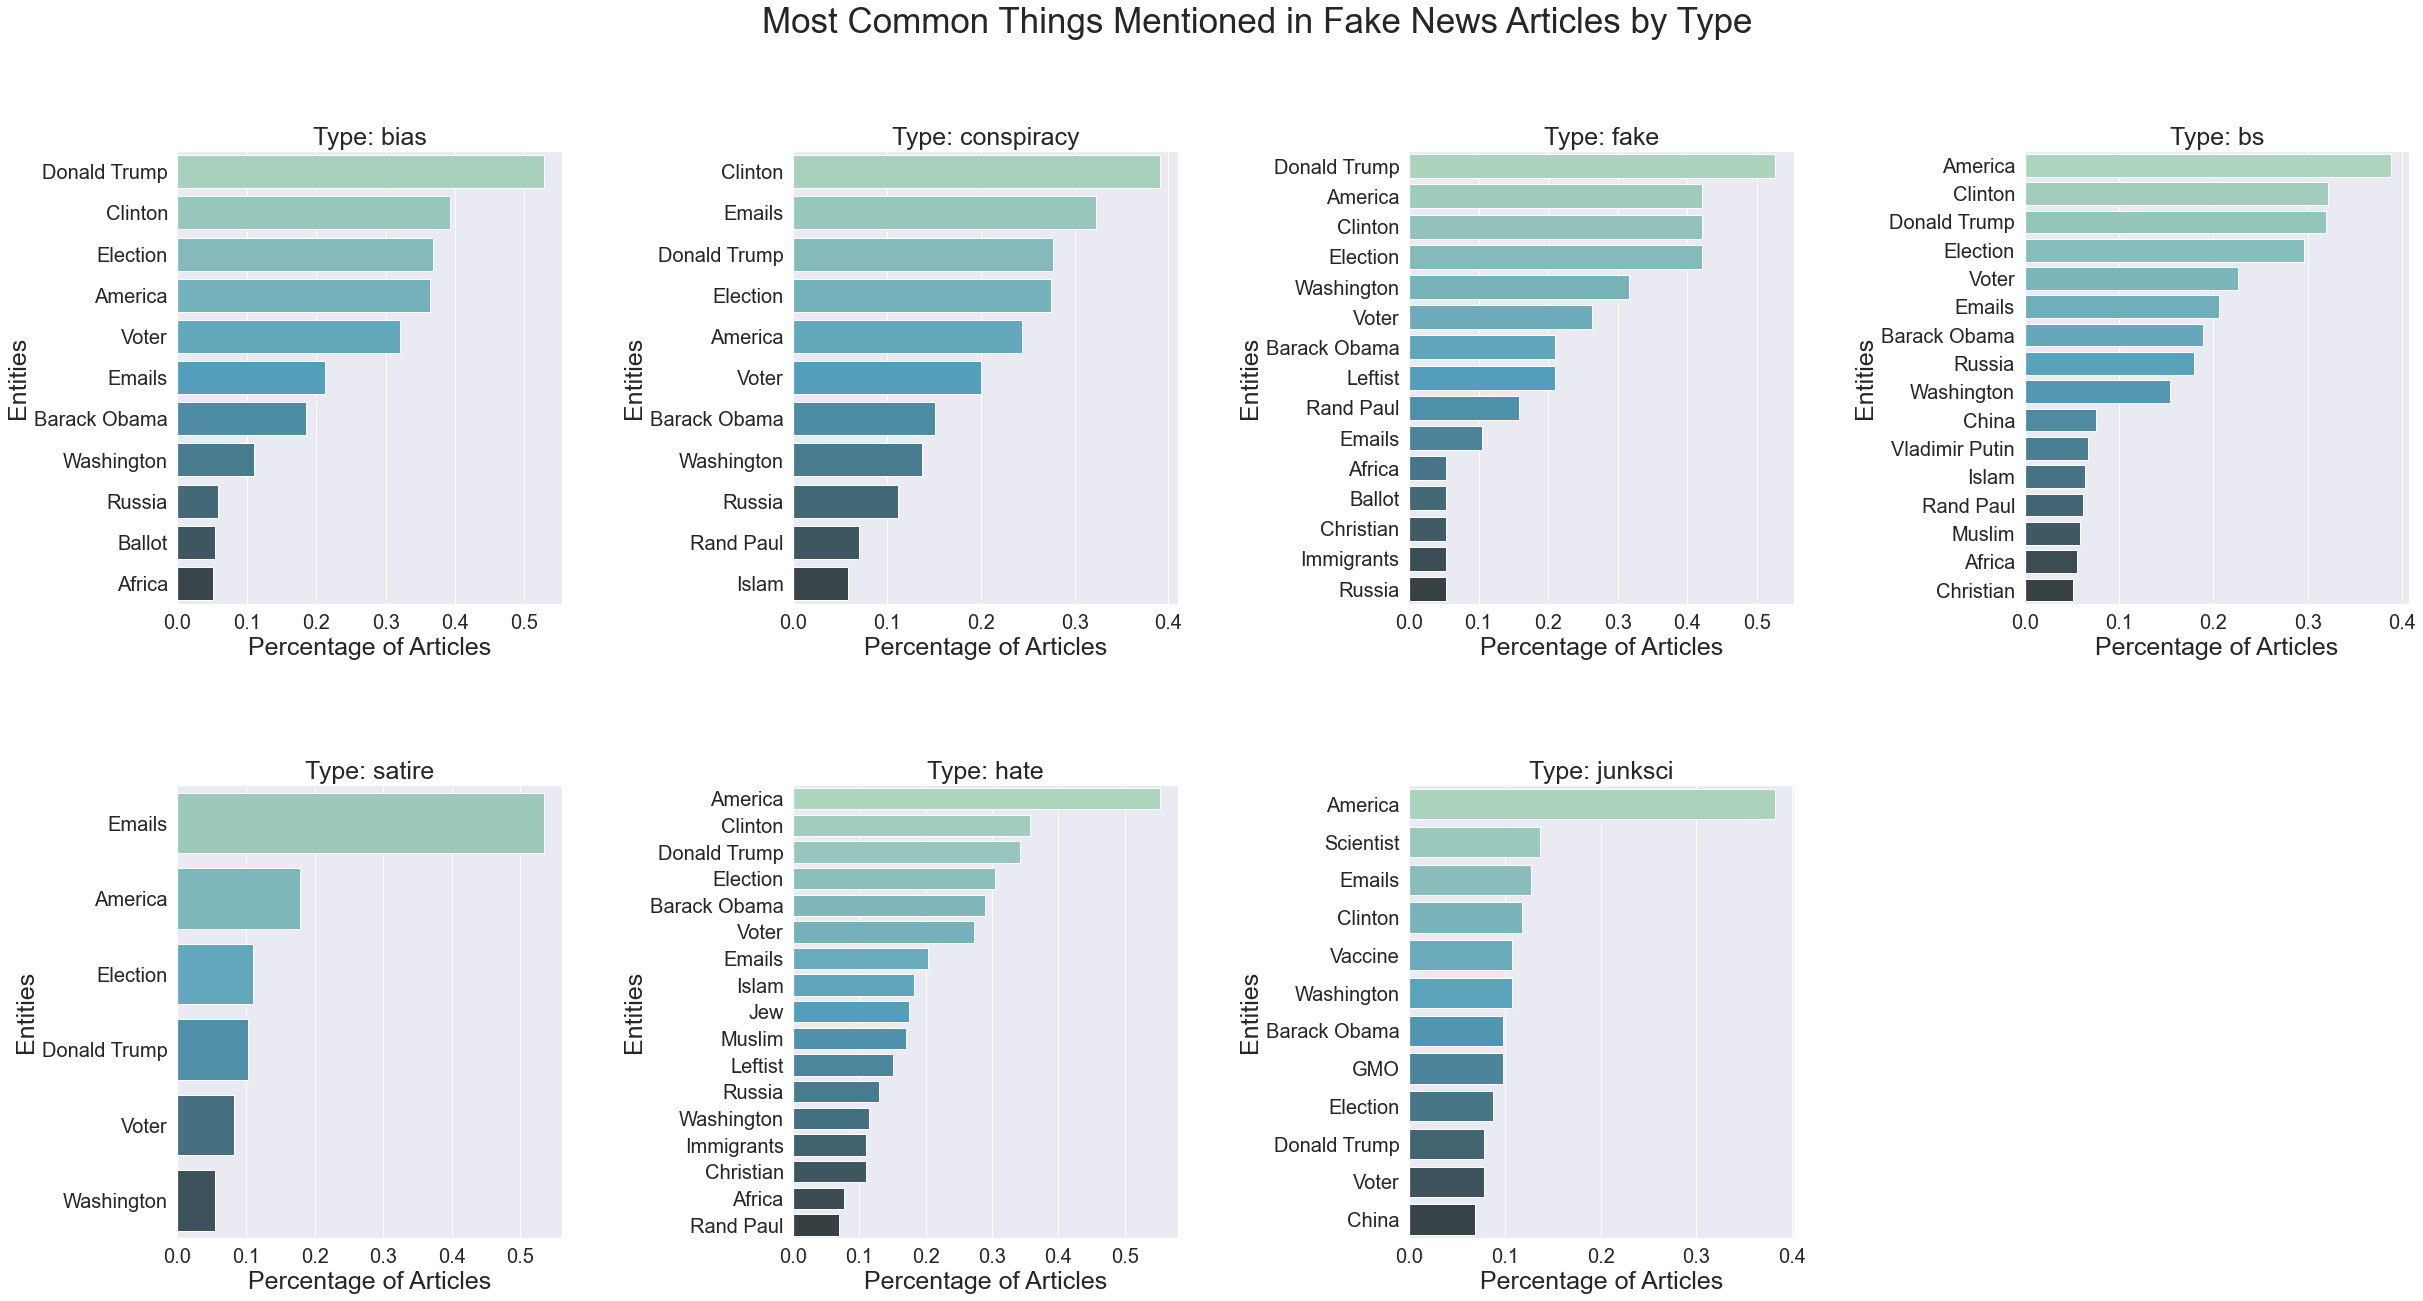

In [40]:
# rcParams['figure.figsize'] = 36,18

fig, axes = plt.subplots(2, 4)
fig.set_size_inches(40, 20)
fig.subplots_adjust(hspace = 0.4, wspace = 0.6)

for i, ax in enumerate(axes.flatten()):
    if i == 7:
        break
    t = types[i]
    matches = {}
    matches_df = df[df['type'] == t]
    
    for label, target in targets:
        amount = matches_df['text_normalized'].str.contains(r"{}".format(target)).sum() / len(matches_df)
        matches[label] = amount
        
    matches = {k:v for k, v in matches.items() if v > 0.05}    
    temp = pd.DataFrame(matches.items(), columns = ['entity', 'percent'])
    temp = temp.sort_values(['percent'], ascending = False)
    num_items = len(matches.keys())
    
    grid = sns.barplot(x = temp['percent'], y = temp['entity'],
                       palette = sns.color_palette('GnBu_d',  num_items), ax = ax)
    
    grid.tick_params(labelsize = 20)
    grid.set_ylabel('Entities', fontsize = 25)
    grid.set_xlabel('Percentage of Articles',  fontsize = 25)
    grid.set_title(f"Type: {t}", fontsize = 25)
fig.suptitle("Most Common Things Mentioned in Fake News Articles by Type", fontsize = 35)

fig.delaxes(ax) 

<h2>Grouped Barplot</h2>

In [70]:
pd.DataFrame(lsts, columns = [cols])

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,bias,23,161,24,82,6,22,174,234,163,...,14,12,15,26,7,2,0,12,142,49
1,conspiracy,12,105,15,65,12,19,168,119,118,...,1,8,30,48,8,6,4,16,86,59
2,fake,1,8,1,4,0,1,8,10,8,...,0,0,3,1,0,0,0,0,5,6
3,bs,633,4460,443,2166,869,592,3690,3664,3404,...,63,317,705,2061,441,188,94,767,2591,1775
4,satire,1,26,4,5,1,1,5,15,16,...,0,2,5,0,3,0,0,0,12,8
5,hate,19,136,5,71,5,27,88,84,75,...,1,6,17,32,3,5,0,9,67,28
6,junksci,5,39,3,10,7,1,12,8,9,...,0,1,2,4,14,1,11,1,8,11
7,state,12,25,1,9,7,1,14,12,17,...,0,0,0,25,5,2,1,4,14,20


In [73]:
lsts = []

for t in types:
    lst = []
    lst.append(t)
    matches_df = df[df['type'] == t]
    
    for label, target in targets:
        amount = matches_df['text_normalized'].str.contains(r"{}".format(target)).sum()
        lst.append(amount)
    lsts.append(lst)
    
cols = ['entity'] + labels
by_type = pd.DataFrame(lsts, columns = [cols])

In [78]:
def pct(r):
    tot = r.sum()
    for item in s:
        r[item] = item /  tot
    return r

In [91]:
by_type.dtypes(

TypeError: 'Series' object is not callable

<AxesSubplot:>

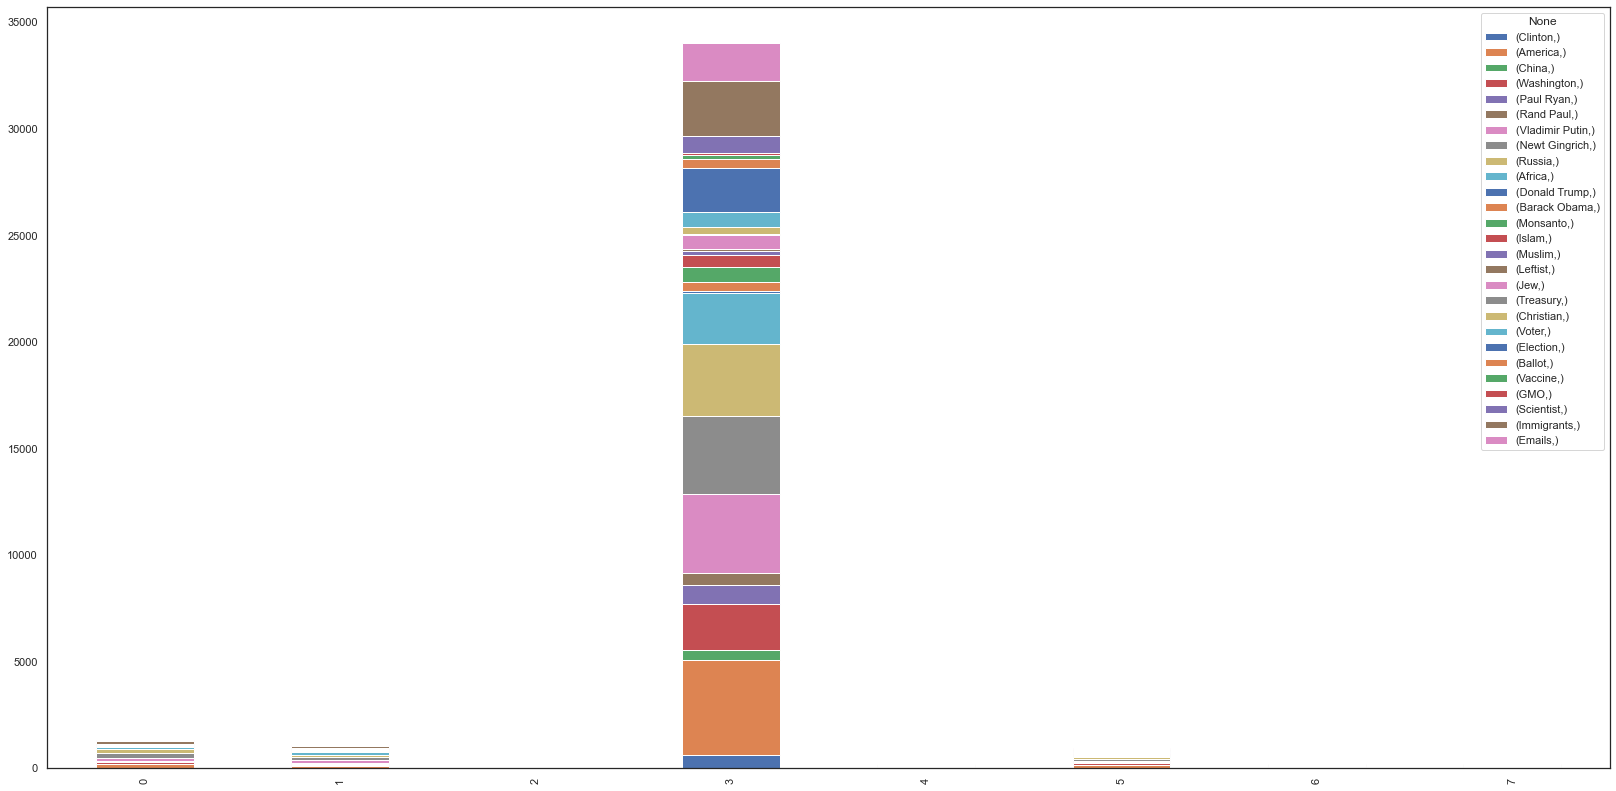

In [76]:
sns.set(style='white')

#create stacked bar chart
by_type.plot(kind='bar', stacked=True)

KeyError: 'percent'

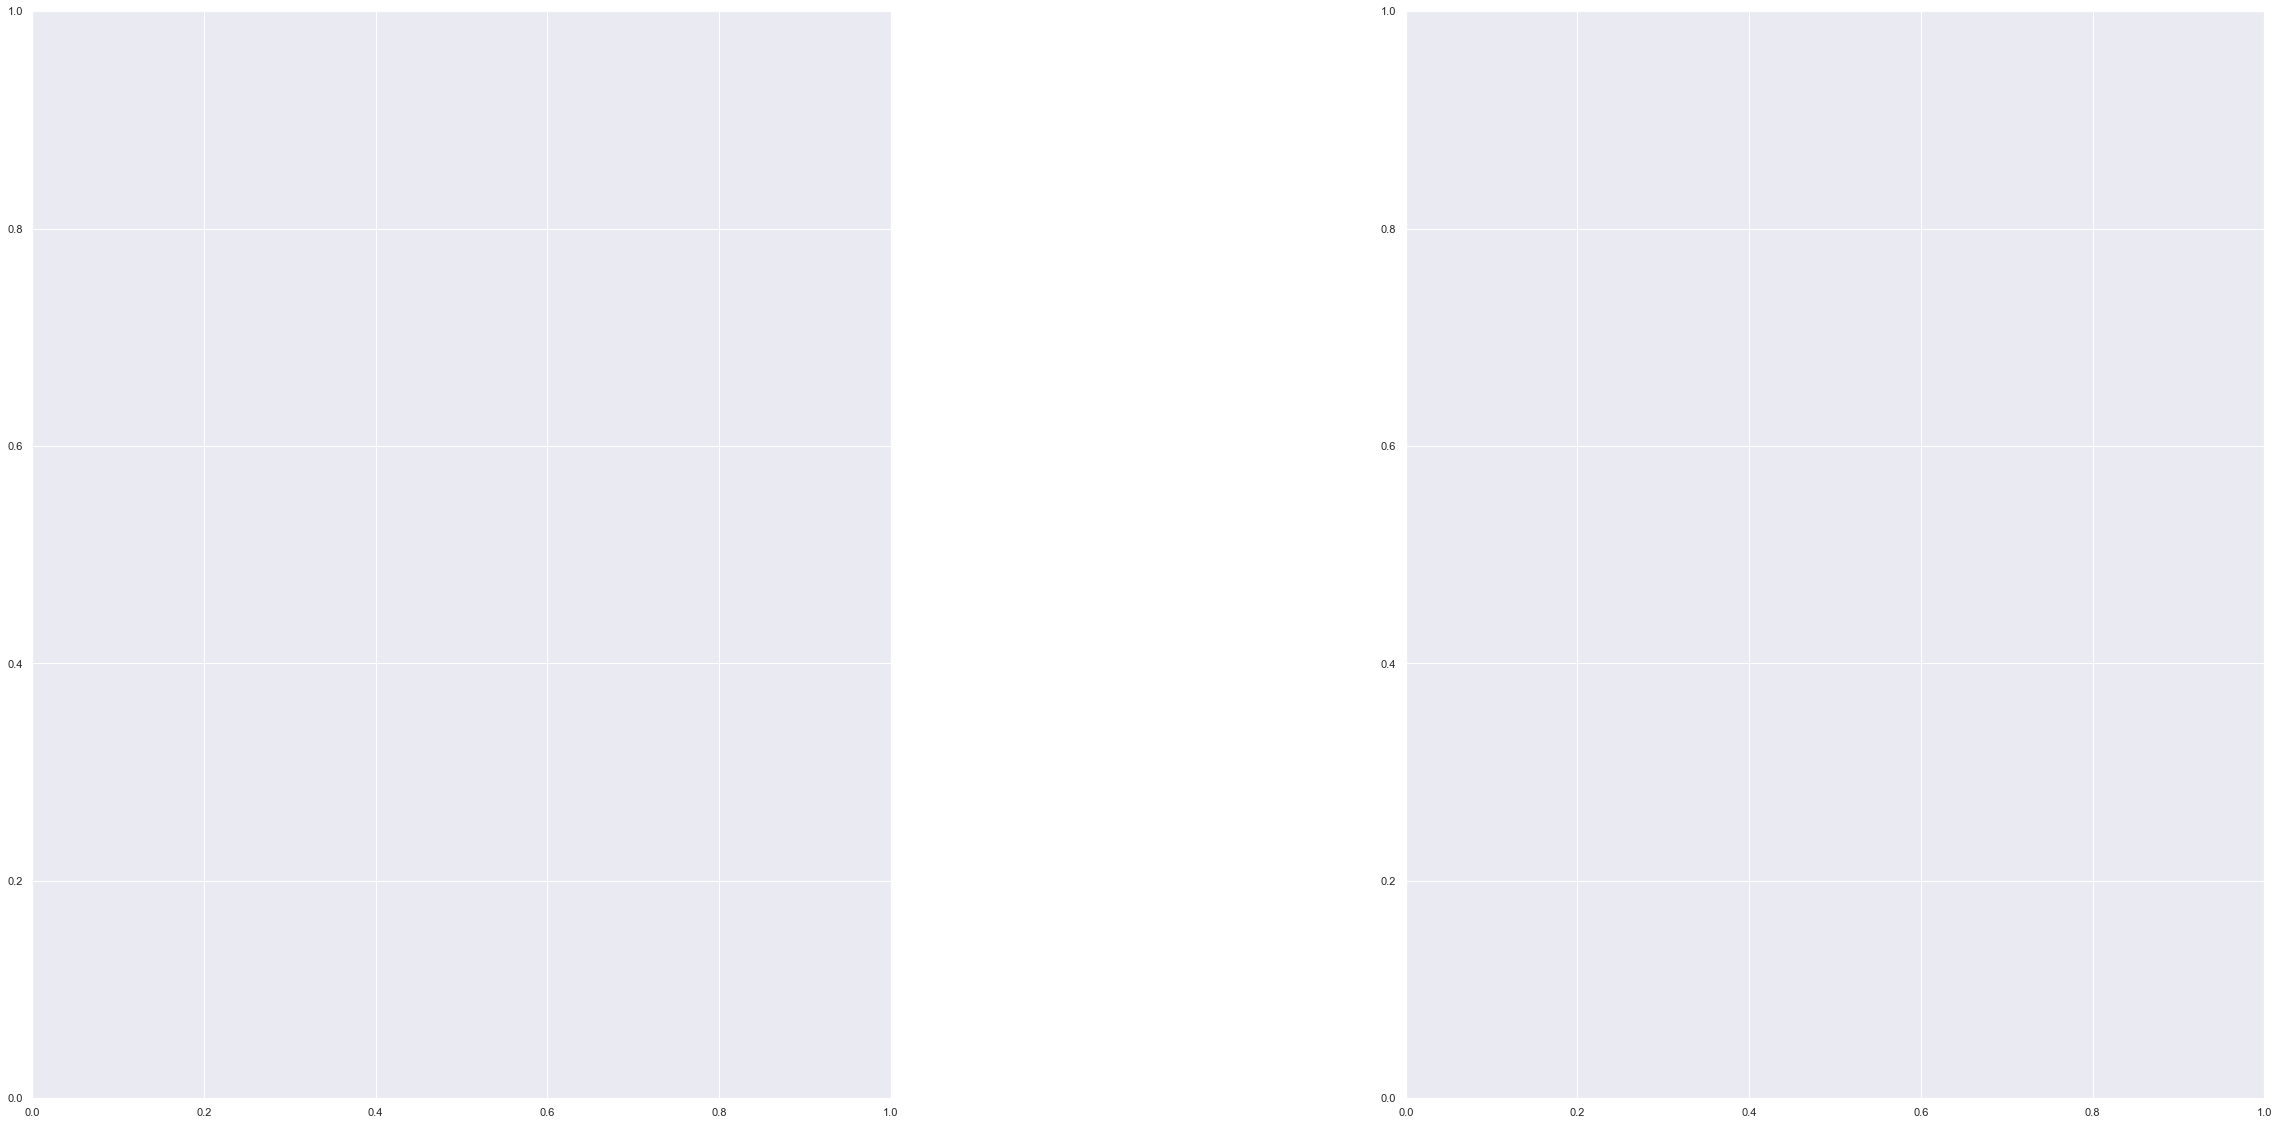

In [49]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(40, 20)
fig.subplots_adjust(hspace = 0.4, wspace = 0.6)

for i, ax in enumerate(axes.flatten()):
    if i == 7:
        break
    dfs = []
    for t in types:
        matches = {}
        matches_df = df[df['type'] == t]
    
        for label, target in targets:
            amount = matches_df['text_normalized'].str.contains(r"{}".format(target)).sum()
            matches[label] = amount

#         matches = {k:v for k, v in matches.items() if v > 0.01}    
        temp = pd.DataFrame(matches.items(), columns = ['entity', t])
        dfs.append(temp)
    
    pcts = pd.concat(dfs)
#     temp = temp.sort_values(['percent'], ascending = False)
    
    grid = sns.barplot(x = pcts['percent'], y = pcts['entity'], hue = pcts['type'], ax = ax)
    
    grid.tick_params(labelsize = 20)
    grid.set_ylabel('Entities', fontsize = 25)
    grid.set_xlabel('Percentage of Articles',  fontsize = 25)
    grid.set_title(f"Type: {t}", fontsize = 25)
fig.suptitle("Most Common Things Mentioned in Fake News Articles by Type", fontsize = 35)

fig.delaxes(ax) 

In [52]:
dfs[0]

,entity,bias
0,Africa,23
1,America,161
2,Ballot,24
3,Barack Obama,82
4,China,6
5,Christian,22
6,Clinton,174
7,Donald Trump,234
8,Election,163
9,Emails,94
